# Lab 5: Regression and Dimensionality Reduction

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle


# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [55]:
# Style plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,9)

## EDA

In [3]:
df = pd.read_csv("./winequality-white.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df['quality'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

In [5]:
# Check for NaNs/Outliers
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

We can see there are no missing values. 

### Data Visualization

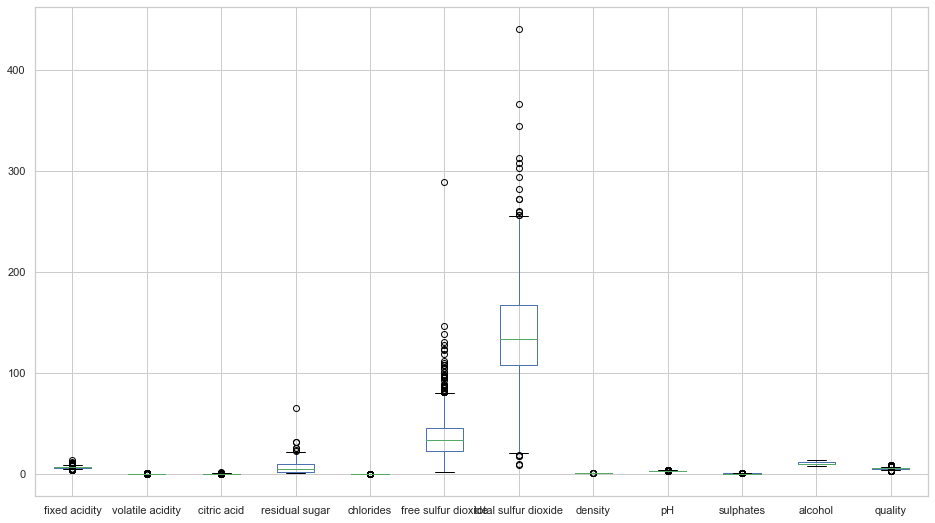

In [57]:
df.boxplot()
plt.show()

We can see that most columns contain outliers. However, `residual sugar`, `free sulfur dioxide` and `total sulfur dioxide` appear to contain the most prominent outliers (at this perspective). 
`RobustScaler`  and log transformation will be applied to these, the rest of the columns will have the `StandardScaler` applied, except quality. 

#### However, it is worth noting that if the features are drilled down into further  (see below) we can clearly see there are numerous outliers. 

So, perhaps they need further attention??

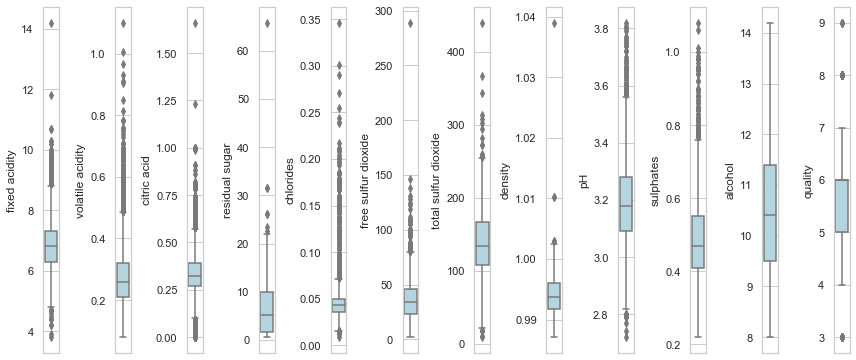

In [50]:
l = df.columns.values
number_of_columns=12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='lightblue',orient='v')
    plt.tight_layout()

### Plots/Maps

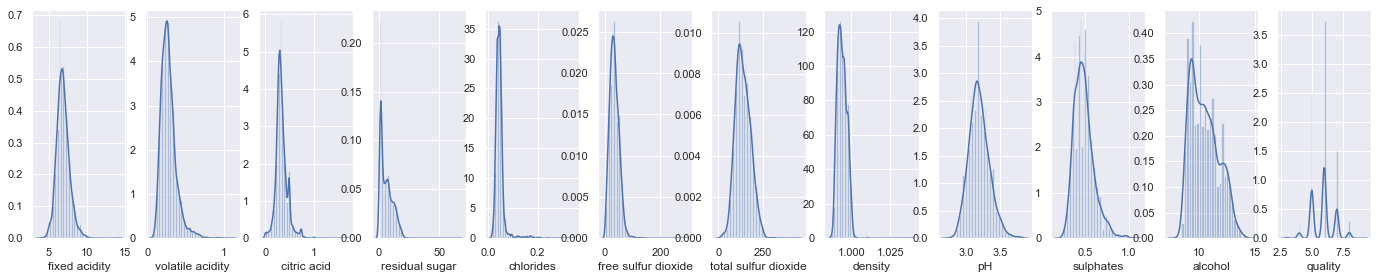

In [39]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

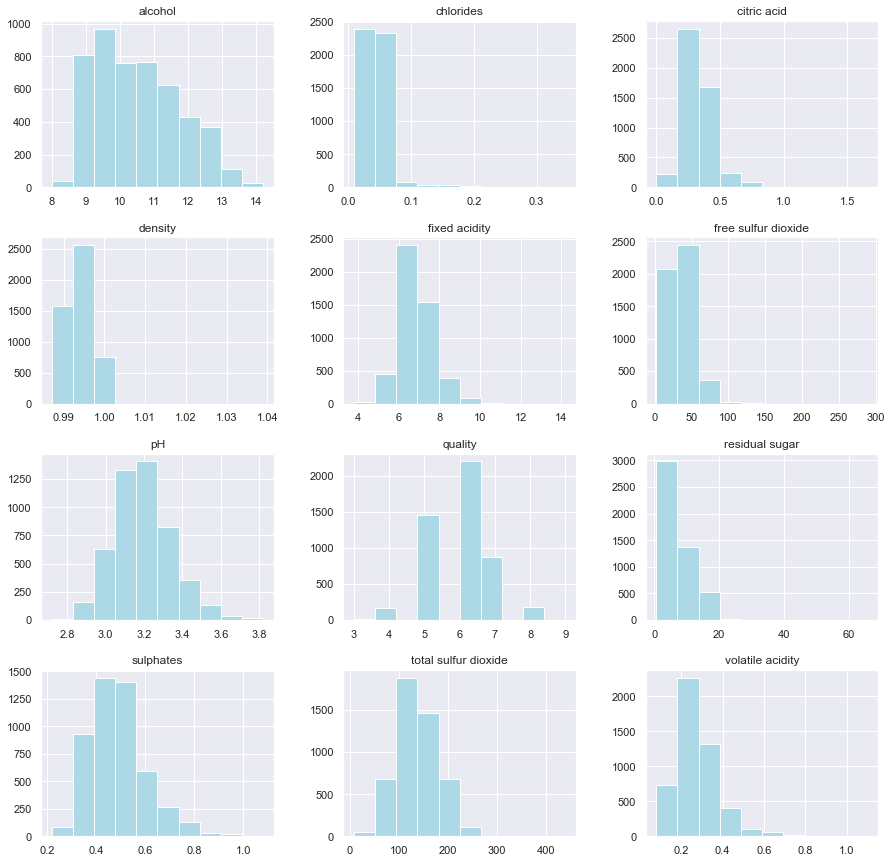

In [25]:
# Features for the wine data
sns.set()
pd.DataFrame.hist(df, figsize = [15,15], color='lightblue')
plt.show()

We can see from the above plots that the ditribution is right (positively) skewed for the majority of the features, with the exception of `pH` - which is normally distributed.

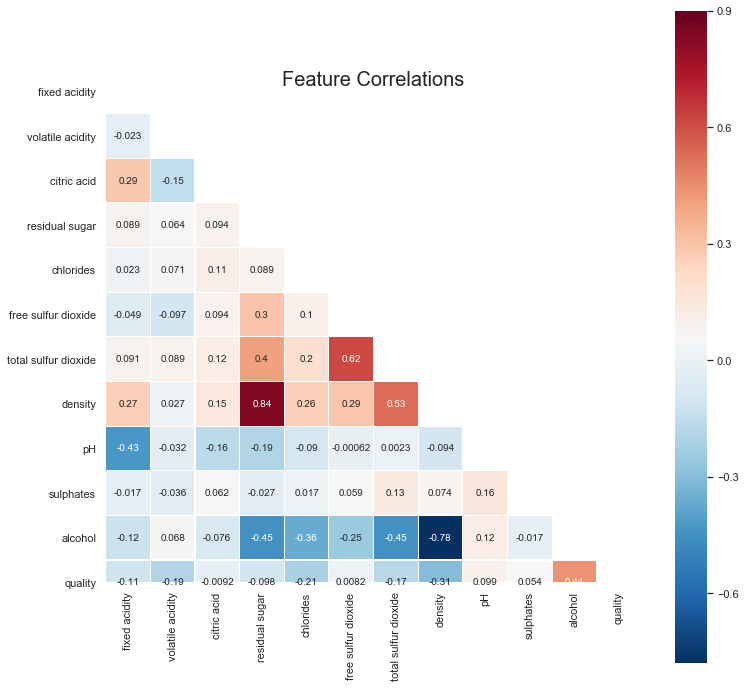

In [51]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (12,12))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

We could infer from the above correlation map that there's a strong negative correlation between `density` & `alcohol` and also, there's a strong positive correlation between `density` & `residual sugar`. It is also worth noting that there is almost no correlation between `quality` & `free sulphur dioxide` and `quality` & `citric acid`. 
* given the lack of correlation - both features could be considered for dropping


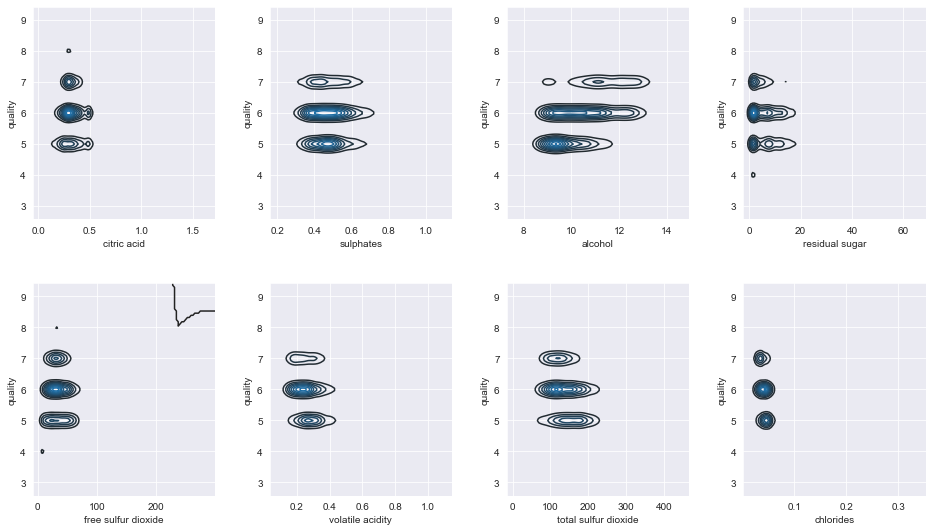

In [19]:
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

plt.subplot(241) 
sns.kdeplot(df['citric acid'], df['quality'])
plt.subplot(242)
sns.kdeplot(df['sulphates'], df['quality'])
plt.subplot(243)
sns.kdeplot(df['alcohol'], df['quality'])
plt.subplot(244)
sns.kdeplot(df['residual sugar'], df['quality'])

plt.subplot(245)
sns.kdeplot(df['free sulfur dioxide'], df['quality'])
plt.subplot(246)
sns.kdeplot(df['volatile acidity'], df['quality'])
plt.subplot(247)
sns.kdeplot(df['total sulfur dioxide'], df['quality'])
plt.subplot(248)
sns.kdeplot(df['chlorides'], df['quality'])
plt.show()

In [58]:
sns.kdeplot?

We can see that most columns contain outliers. However, `residual sugar`, `free sulfur dioxide` and `total sulfur dioxide` appear to contain the most prominent outliers. `RobustScaler`  and log transformation will be applied to these (for this run), the rest of the columns will have the `StandardScaler` applied, except quality. 

As we can see from the above boxplots (excluding `quality`and `alcohol`), there are numerous outliers for each attribute. For this reason I will run this again, separately, with the features containing outliers included. For now the above mentioned wil be included in the application of the log transformation and the `RobustScaler`. 

## Data Preparation

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the two columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other columns (except `quality`) to which we will apply `StandardScaler`.

In [60]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['quality']]

In [61]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['quality']]

# define column groups with the same data preparation
names_outliers = ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide']
names_no_outliers = list(set(names_all) - set(names_outliers))

After splitting a dataset into a training and test sets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns. 

In [62]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.

In [63]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

Finally, we can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the groups of columns and unites them with `FeatureUnion`. 

In [64]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [65]:
y = df['quality']
X = df.drop('quality', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Although we treat `quality` as a numerical attribute, it is in fact ordinal, and we can still do a stratified split to ensure that the distribution of wine qualities is the same in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [66]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [67]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, cv=10, iid = False, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.391:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                  gamma='auto', kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=11, step=1, verbose=0), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 8}


We explicitly assign the `False` to the parameter `iid` of `GridSearchCV` to avoid a deprecation warning. The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

In [ ]:
# Create RF classification model with GridSearchCV
# n_estimators: The number of trees in the forest.
# criterion, min_samples_split and min_samples_leaf are same to decision tree parameters.

from sklearn.ensemble import RandomForestClassifier

rf_grid = {"n_estimators": [50, 100, 150], "criterion": ["gini", "entropy"],
           "min_samples_split":[3,4,5,6,7,8,9,10], "min_samples_leaf":[1,2,3,4,5,6,7,8,9]}
rforest = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=10, iid=False)
rforest.fit(X_train, y_train)

print("RF Tuned Hyperparameters", rforest.best_params_)
print("RF Tuned Best Score:", round(rforest.best_score_,3))

C:\Users\wyer2\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


### Linear Regression Pipeline

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## 3rd Regression algo 
### Ensemble methods - Ada or GradBoost

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [ ]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

We will use a Pandas bar plot to compare the results. 

In [ ]:
RF_metrics = np.array([RF_mse, RF_mae, RF_r2])
LR_metrics = np.array([LR_mse, LR_mae, LR_r2])
index = ['MSE', 'MAE', 'R2']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [ ]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [ ]:
filename = 'final_model_lab5.sav'
pickle.dump(final_model, open(filename, 'wb'))